<a href="https://colab.research.google.com/github/camelliatea/dicoding-proyek-machine-learning/blob/main/%5BKlasifikasi%5D_Submission_Akhir_BMLP_Elita_Camellia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [31]:
# Mengimport library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [32]:
# Menghubungkan gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Memuat dataset hasil clustering
df = pd.read_csv('/content/drive/My Drive/data/Dataset_clustering.csv', parse_dates=['Order_Date'])
df.head()

,Order_ID,Customer_ID,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date,Cluster,Customer_Type
0,ORD380336,CUS4552,Krombacher,Alcoholic Beverages,1.59,9,0.00,14.31,Niedersachsen,2022-01-19,1,B2C
1,ORD1627499,CUS7701,Apollinaris,Water,1.13,65,0.10,101.70,Mecklenburg-Vorpommern,2023-07-06,0,B2B
2,ORD1997448,CUS876,Evian,Water,1.31,2,0.00,2.62,Berlin,2023-11-15,1,B2C
3,ORD1374916,CUS2392,Fritz-Kola,Soft Drinks,2.50,26,0.05,61.75,Hamburg,2022-06-04,0,B2B
4,ORD1383108,CUS5210,Vittel,Water,0.56,15,0.00,8.40,Sachsen,2021-11-08,1,B2C


In [34]:
# Menampilkan informasi umum tentang dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order_ID       25000 non-null  object        
 1   Customer_ID    25000 non-null  object        
 2   Product        25000 non-null  object        
 3   Category       25000 non-null  object        
 4   Unit_Price     25000 non-null  float64       
 5   Quantity       25000 non-null  int64         
 6   Discount       25000 non-null  float64       
 7   Total_Price    25000 non-null  float64       
 8   Region         25000 non-null  object        
 9   Order_Date     25000 non-null  datetime64[ns]
 10  Cluster        25000 non-null  int64         
 11  Customer_Type  25000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 2.3+ MB


In [35]:
# Memeriksa missing values
print(f'Missing values per fitur:\n{df.isnull().sum()}')

Missing values per fitur:
Order_ID         0
Customer_ID      0
Product          0
Category         0
Unit_Price       0
Quantity         0
Discount         0
Total_Price      0
Region           0
Order_Date       0
Cluster          0
Customer_Type    0
dtype: int64


In [36]:
# Menghapus kolom yang tidak relevan
df = df.drop(columns=['Order_ID', 'Customer_ID', 'Product', 'Order_Date','Customer_Type'], axis=1)
df.head()

,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Cluster
0,Alcoholic Beverages,1.59,9,0.00,14.31,Niedersachsen,1
1,Water,1.13,65,0.10,101.70,Mecklenburg-Vorpommern,0
2,Water,1.31,2,0.00,2.62,Berlin,1
3,Soft Drinks,2.50,26,0.05,61.75,Hamburg,0
4,Water,0.56,15,0.00,8.40,Sachsen,1


In [37]:
# Pisahkan fitur (X) dan target (y) setelah normalisasi
X = df.drop(columns=['Cluster'])
y = df['Cluster']

In [38]:
X.head()

,Category,Unit_Price,Quantity,Discount,Total_Price,Region
0,Alcoholic Beverages,1.59,9,0.00,14.31,Niedersachsen
1,Water,1.13,65,0.10,101.70,Mecklenburg-Vorpommern
2,Water,1.31,2,0.00,2.62,Berlin
3,Soft Drinks,2.50,26,0.05,61.75,Hamburg
4,Water,0.56,15,0.00,8.40,Sachsen


In [39]:
y.head()

,Cluster
0,1
1,0
2,1
3,0
4,1


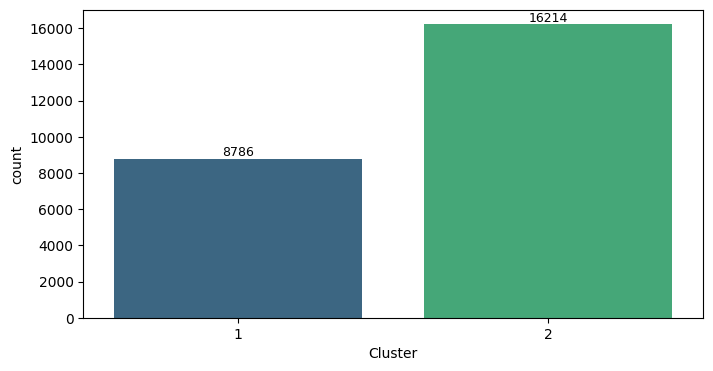

In [40]:
# Melihat visualisasi distribusi variabel target
plt.figure(figsize=(8, 4))
bars = sns.countplot(x='Cluster', data=df, palette='viridis', hue='Cluster', legend=False)
# Mengubah label x agar menjadi Cluster+1
cluster_labels = [str(int(tick.get_text()) + 1) for tick in bars.get_xticklabels()]
plt.xticks(ticks=range(len(cluster_labels)), labels=cluster_labels)

# Menambahkan label nilai di atas setiap bar
for bar in bars.patches:
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9, color='black')
plt.show()

Insight:

Berdasarkan diagram batang di atas, dapat diketahui bahwa Cluster 1 memiliki 16.214 data transaksi sementara Cluster 2 hanya mencakup 8.786 data transaksi.

**Label Encoder**

In [41]:
# Encoding pada fitur kategorikal menggunakan LabelEncoder
label_encoder = LabelEncoder()

# List kolom kategorikal yang perlu di-encode
categorical_columns = X.select_dtypes(include=[object])

# Encode kolom kategorikal
for column in categorical_columns:
    X[column] = label_encoder.fit_transform(X[column])

X.head()

,Category,Unit_Price,Quantity,Discount,Total_Price,Region
0,0,1.59,9,0.00,14.31,8
1,3,1.13,65,0.10,101.70,7
2,3,1.31,2,0.00,2.62,2
3,2,2.50,26,0.05,61.75,5
4,3,0.56,15,0.00,8.40,12


In [42]:
# Normalisasi Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [43]:
# Membagi dataset menjadi training dan testing (80% training dann 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f'Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 20000, Test size: 5000


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [44]:
# Membangun model Logistic Regression
LR_model = LogisticRegression(random_state=42)
LR_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [45]:
# Membangun model Random Forest
RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [46]:
# Fungsi untuk mengevaluasi model serta mengembalikan hasilnya
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    results = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    return results

In [47]:
# Mengevaluasi setiap model menggunakan data train
results_train = {
    'LR': evaluate_model(LR_model, X_train, y_train),
    'RF': evaluate_model(RF_model, X_train, y_train)
}

# Membuat DataFrame untuk meringkas hasil
train_summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])


# Mengisi DataFrame dengan hasil
rows = []
for model_name, metrics in results_train.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

# Mengonversi daftar kamus ke DataFrame
train_summary_df = pd.DataFrame(rows)

print(train_summary_df)


  Model  Accuracy  Precision  Recall  F1-Score
0    LR    0.9662   0.950217     1.0  0.974473
1    RF    1.0000   1.000000     1.0  1.000000


**Penjelasan singkat mengenai algoritma yang digunakan**
1. **Logistic Regression (LR)**

    Logistic Regression (LR) merupakan algoritma machine learning yang umumnya digunakan untuk klasifikasi biner atau multikategori. Algoritma ini memprediksi probabilitas suatu data masuk ke dalam kategori tertentu menggunakan fungsi logit (sigmoid), yang menghasilkan output antara 0 dan 1. Logistic Regression bekerja dengan baik jika terdapat hubungan linier antara variabel independen dan variabel target. Selain itu, algoritma ini mudah diinterpretasikan sehingga cukup populer dalam analisis statistik dan machine learning sederhana, terutama untuk memahami pengaruh setiap variabel terhadap hasil prediksi.

2. **Random Forest (RF)**

    Random Forest (RF) adalah algoritma machine learning yang menggunakan banyak Decision Tree untuk meningkatkan akurasi dan stabilitas prediksi.  Setiap pohon keputusan dalam Random Forest mempelajari subset data dan fitur yang berbeda sehingga setiap pohon memiliki perspektif unik terhadap data. Hasil akhir diperoleh dengan rata-rata prediksi (untuk regresi) atau voting mayoritas (untuk klasifikasi) dari semua pohon. Algoritma ini sangat cocok untuk menangani data yang kompleks, baik dalam tugas klasifikasi maupun regresi, lebih tahan terhadap overfitting, serta mampu memberikan wawasan tentang fitur yang paling berpengaruh dalam prediksi.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [48]:
# Melatih model menggunakan data test

# Mengevaluasi setiap model serta mengumpulkan hasilnya
results_test = {
    'LR': evaluate_model(LR_model, X_test, y_test),
    'RF': evaluate_model(RF_model, X_test, y_test)
}

# Membuat DataFrame untuk meringkas hasil
test_summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])


# Mengisi DataFrame dengan hasil
rows = []
for model_name, metrics in results_test.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

# Mengonversi daftar kamus ke DataFrame
test_summary_df = pd.DataFrame(rows)

print(test_summary_df)

  Model  Accuracy  Precision  Recall  F1-Score
0    LR    0.9654   0.950344     1.0   0.97454
1    RF    1.0000   1.000000     1.0   1.00000


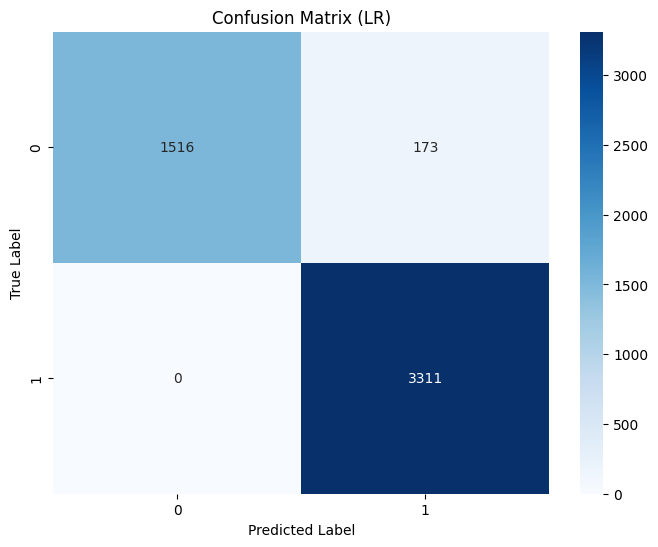

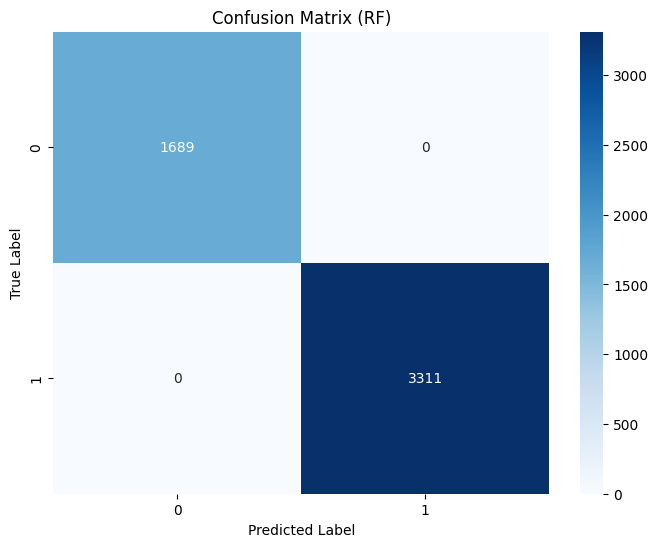

In [49]:
# Visualisasi Confusion Matrix
for model_name, metrics in results_test.items():
    cm = metrics['Confusion Matrix']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.title(f'Confusion Matrix ({model_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Insight:

**Logistic Regression**

Model Logistic Regression menunjukkan performa yang sangat baik dengan recall 100%, yang berarti model ini mampu mengidentifikasi semua kasus positif dengan benar. Namun, presisinya menunjukkan skor yang sedikit lebih rendah (95.03%), yang menunjukkan adanya beberapa kasus negatif yang diklasifikasikan sebagai positif. Berdasarkan confusion matrixnya, model LR mencakup 3311 True Positive (TP), 1689 True Negatives (TN), serta 173 False Positives (FP) dan 0 False Negatives (FN).

**Random Forest**

Model RF terlihat meimiliki performa yang sempurna dengan skor 100% di semua metrik. Ini dapat memberikan dua kemungkinan, bisa jadi model sangat kuat atau terjadi overfitting.Berdasarkan confusion matrixnya, model RF mencakup 3311 True Positive (TP), 1689 True Negatives (TN), serta 0 False Positives (FP) dan False Negatives (FN). Perlu di lakukan validasi tambahan untuk memastikan kemungkinan overfitting bahwa model tidak mengalami overfitting terhadap data pelatihan.


## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [50]:
# RandomizedSearchCV untuk Logistic Regression
param_dist = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Inisialisasi RandomSearchCV
lr_random_search = RandomizedSearchCV(LR_model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
lr_random_search.fit(X_train, y_train)

# Mengambil hyperparameter terbaik
print('Best Parameters:', lr_random_search.best_params_)
best_logreg = lr_random_search.best_estimator_

# Evaluasi performa model pada test set
lr_score = best_logreg.score(X_test, y_test)
print(f'Accuracy after Grid Search: {lr_score:.2f}')

Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(1438.44988828766)}
Accuracy after Grid Search: 1.00


In [51]:
# RandomizedSearchCV untuk Random Forest
param_dist = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Inisialisasi RandomSearchCV
rf_random_search = RandomizedSearchCV(RF_model, param_distributions=param_dist, n_iter=15, cv=5, n_jobs=-1, random_state=42, verbose=1)
rf_random_search.fit(X_train, y_train)

# Mengambil hyperparameter terbaik
print('Best Parameters:', rf_random_search.best_params_)
best_rf = rf_random_search.best_estimator_

# Evaluasi performa model pada test set
rf_score = best_rf.score(X_test, y_test)
print(f'Accuracy after Grid Search: {rf_score:.2f}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'n_estimators': np.int64(300), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}
Accuracy after Grid Search: 1.00


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [52]:
# Mendefiniskan model dengan hyperparameter terbaik yang diperoleh dari proses tuning
models = {
    'Tuned LR': best_logreg,
    'Tuned RF': best_rf
}

# Mengevaluasi model yang telah dituning menggunakan fungsi evaluate_model
results_tuned = {
    'LR': evaluate_model(best_logreg, X_test, y_test),
    'RF': evaluate_model(best_rf, X_test, y_test)
}

# Membuat DataFrame untuk meringkas hasil
tuned_summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])


# Mengisi DataFrame dengan hasil
rows = []
for model_name, metrics in results_tuned.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

# Mengonversi daftar kamus ke DataFrame
tuned_summary_df = pd.DataFrame(rows)

# Tampilkan hasil evaluasi
print('Ringkasan Hasil Evaluasi Model Setelah Tuning:\n', tuned_summary_df)

Ringkasan Hasil Evaluasi Model Setelah Tuning:
   Model  Accuracy  Precision  Recall  F1-Score
0    LR       1.0        1.0     1.0       1.0
1    RF       1.0        1.0     1.0       1.0


## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

**1. Membandingkan Hasil Evaluasi**

In [53]:
print(f'Hasil Evaluasi Model Sebelum Tuning [Test Data]\n{test_summary_df}\n\nHasil Evaluasi Model Setelah Tuning [Test Data]\n{tuned_summary_df}')

Hasil Evaluasi Model Sebelum Tuning [Test Data]
  Model  Accuracy  Precision  Recall  F1-Score
0    LR    0.9654   0.950344     1.0   0.97454
1    RF    1.0000   1.000000     1.0   1.00000

Hasil Evaluasi Model Setelah Tuning [Test Data]
  Model  Accuracy  Precision  Recall  F1-Score
0    LR       1.0        1.0     1.0       1.0
1    RF       1.0        1.0     1.0       1.0


- Setelah tuning, performa model Logistic Regression meningkat secara signifikan. Awalnya, model memiliki akurasi 96.54%, precision 95.03%, dan F1-score 97.45%, sementara recall tetap stabil di 100%. Setelah tuning, semua metrik meningkat menjadi 100% (1.0). Peningkatan terbesar terjadi pada precision yang sebelumnya paling rendah.
- Model Random Forest sudah mencapai performa sempurna (100%) sebelum tuning, dengan akurasi, precision, recall, dan F1-score semuanya bernilai 1.0. Setelah tuning, hasilnya tetap tidak berubah, yang berarti tuning tidak memberikan dampak signifikan karena model sudah optimal sejak awal.



**2. Identifikasi Kelemahan**

In [54]:
print(f'Hasil Latihan Model [Train Data]\n{train_summary_df}\n\nHasil Evaluasi Model Sebelum Tuning [Test Data]\n{test_summary_df}\n\nHasil Evaluasi Model Setelah Tuning [Test Data]\n{tuned_summary_df}')

Hasil Latihan Model [Train Data]
  Model  Accuracy  Precision  Recall  F1-Score
0    LR    0.9662   0.950217     1.0  0.974473
1    RF    1.0000   1.000000     1.0  1.000000

Hasil Evaluasi Model Sebelum Tuning [Test Data]
  Model  Accuracy  Precision  Recall  F1-Score
0    LR    0.9654   0.950344     1.0   0.97454
1    RF    1.0000   1.000000     1.0   1.00000

Hasil Evaluasi Model Setelah Tuning [Test Data]
  Model  Accuracy  Precision  Recall  F1-Score
0    LR       1.0        1.0     1.0       1.0
1    RF       1.0        1.0     1.0       1.0


- Random Forest (RF) kemungkinan mengalami overfitting karena dari sebelum tuning sudah memiliki akurasi sempurna (100%) pada data uji. Biasanya, performa yang terlalu tinggi di data uji mengindikasikan bahwa model terlalu menyesuaikan diri dengan data latih, yang bisa menyebabkan kurang generalisasi pada data baru.
- Logistic Regression sebelum tuning lebih realistis dari Random Forest, dengan akurasi 96.54%, yang menunjukkan bahwa model masih bisa mengalami kesalahan. Namun, setelah tuning mencapai 100%, ada kemungkinan model menjadi terlalu kompleks dan overfitting, terutama jika dataset tidak cukup besar.

**3. Rekomendasi Lanjutan**

- Menambahkan lebih banyak data ke dalam dataset agar model dapat mengenali pola yang lebih beragam. Jika dataset terlalu kecil atau kurang bervariasi, model bisa saja hanya menghafal data latih dan sulit mengenali pola yang lebih umum. Dengan data yang lebih banyak, model dapat belajar lebih baik dan mengurangi risiko overfitting.
-Mencoba algoritma yang lebih sederhana jika model yang digunakan terlalu kompleks untuk data yang tersedia. Algoritma yang lebih ringan mungkin dapat meningkatkan performa model tanpa perlu beban komputasi yang besar.
- Menggunakan cross-validation untuk memastikan model stabil dan tidak hanya bekerja baik pada sebagian kecil data. Metode ini membagi dataset menjadi beberapa bagian untuk melatih dan menguji model secara bergantian, sehingga hasil yang diperoleh lebih akurat dan mengurangi risiko overfitting.